# Exploratory Data Analysis
This notebook creates features from raw tables and visualizes the results.

## 1. Set environment
Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from wordcloud import WordCloud, STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import statsmodels.api as sm
from isodate import parse_duration
from scipy.stats import ttest_ind
from stargazer.stargazer import Stargazer

Read datasets

In [2]:
d1 = pd.read_csv('../../dat/videoDetails.csv')
d2 = pd.read_csv('../../dat/videoFlags.csv')
df = pd.merge(d1, d2, on='videoId', how='right')

## 2. Feature creation
Set date type to `publishedAt`
2021-11-05T12:01:03Z

In [3]:
df['publishedAt'] = pd.to_datetime(df['publishedAt'], format='%Y-%m-%dT%H:%M:%SZ')

Turn `definition` to dummy

In [4]:
df['definition'] = df['definition'].replace({'sd':'0','hd':'1'}).astype(int)

Create targets from counters

In [5]:
for h in [i * 12 for i in  range(1,7)]:
    h = str(h)
    df['ncr1Post' + h] = df['post' + h + 'CommentsNeg1'] / df['post' + h + 'CommentsNum'].replace(0, 0.1)
    df['ncr2Post' + h] = df['post' + h + 'CommentsNeg2'] / df['post' + h + 'CommentsNum'].replace(0, 0.1)

Analyze most important words in video titles to create dummy variables

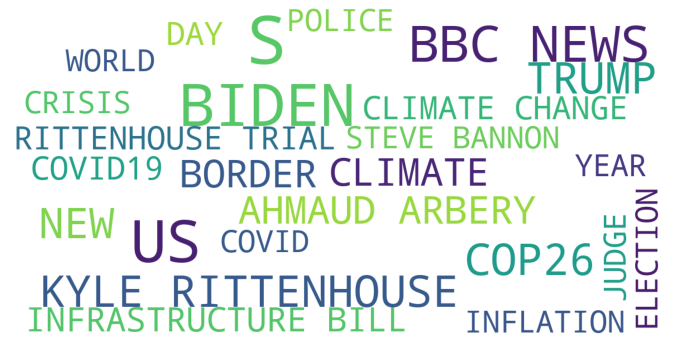

In [6]:
# All titles to single text
text = ' '.join(df['title'].str.title().tolist())

# Remove annoying strings
for string in ["'s",".","-"]:
    text = text.replace(string, '')

# All words to uppercase
text = text.upper()
# Stopwords
stopwords = set(list(STOPWORDS) + ['SAY','SAYS'])

# Plot wordcloud
wordcloud = WordCloud(
    background_color='white',
    max_words=25,
    stopwords=stopwords,
    max_font_size=40, 
    scale=3,
    random_state=42
).generate(text)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [7]:
# Title to lowercase
df['title'] = df['title'].str.lower()

# Dictionary of keywords
keywords = {
    'biden':['biden'],
    'trump':['trump'],
    'rittenhouse':['rittenhouse'],
    'climate':['cop26','cop 26','climate'],
    'border':['border'],
    'economy':['inflation','infrastructure'],
    'covid':['covid','covid19','covid-19'],
    'arbery':['arbery'],
    'bannon':['bannon'],
    'usa':['us','u.s','usa','u.s.a']
}

# Create Indicator variables
for topic in keywords:
    words = keywords[topic]
    df[topic] = np.where(df['title'].str.contains('|'.join(words)), 1, 0)

Video title sentiment

In [8]:
clf = SentimentIntensityAnalyzer()
df['titleSentiment'] = df['title'].apply(lambda x: clf.polarity_scores(x)['compound'])

Translate `duration` to seconds.

In [9]:
# PT format to seconds
df['seconds'] = df['duration'].apply(lambda x: int(parse_duration(x).total_seconds()))

# Convert seconds to log(seconds)
df['logSeconds'] = np.log(df['seconds'])

Sort data by upload date

In [10]:
df = df.sort_values('publishedAt', ascending=True).reset_index(drop=True)

Treatment indicator

In [11]:
df['treat'] = (df['publishedAt'] > '2021-11-10').astype(int)

Declare time (seconds) until treatment and interaction

In [12]:
# Seconds until treatment
df['sut'] = (pd.Timestamp('2021-11-10') - df['publishedAt']).dt.total_seconds()

# Interaction
df['treatSut'] = df['sut'].multiply(df['treat'])

## 3. EDA
List of targets

### 3.1. Descriptive statistics
Number of available videos as a function of $h$

In [13]:
# Columns to use
cols = ['post'+str(i * 12)+'CommentsNum' for i in range(1,7)]

# Merge to get videoId & posthCommentsNum
t = pd.merge(d1[['videoId','publishedAt']], d2[['videoId'] + cols], on='videoId', how='outer')

# Create C&T groups
t['treat'] = np.where(t['publishedAt'] > '2021-11-10', 1, 0)

# Count available videos per window
t[cols] = t[cols].notna().astype(int)

# Group by
t = t.groupby('treat').agg({**{'videoId':'size'}, **dict(zip(cols,['sum']*6))}).transpose()

# Format
t.index = ['Total videos'] + ['h = ' + str(i*12) for i in range(1,7)]

# To latex
print(t.to_latex(caption='Number of available videos for different values of $h$',
                 label='tab_dat_nobs'))

\begin{table}
\centering
\caption{Number of available videos for different values of $h$}
\label{tab_dat_nobs}
\begin{tabular}{lrr}
\toprule
treat &    0 &    1 \\
\midrule
Total videos &  831 &  899 \\
h = 12       &  678 &  855 \\
h = 24       &  583 &  855 \\
h = 36       &  463 &  855 \\
h = 48       &  428 &  855 \\
h = 60       &  344 &  855 \\
h = 72       &  319 &  855 \\
\bottomrule
\end{tabular}
\end{table}



Balance table (conditional on 12$h$)

In [14]:
# Order dummy variables by frequency
X = ['biden','trump','rittenhouse','climate','border','economy','covid','arbery','bannon','usa']
X = df[X].mean().sort_values(ascending=False).index.tolist()

# Add remaining covariates
X = ['titleSentiment','seconds','definition'] + X

# Means by group
t = df.groupby('treat')[X].mean().transpose()

# Calculate p-values of differences
pvals = []
for x in X:
    p = ttest_ind(df.loc[df['treat'].eq(1), x], df.loc[df['treat'].eq(0), x])
    pvals.append(p[1])
t['p'] = pvals

# Change column names
t.columns = ['Control','Treatment','p-value']

# To latex
print(t.to_latex(caption='Balance table for videos with comments posted within first 12 hours ('+str(len(df)) + ')',
                 label='tab_dat_balance', float_format='%.3f'))

\begin{table}
\centering
\caption{Balance table for videos with comments posted within first 12 hours (1533)}
\label{tab_dat_balance}
\begin{tabular}{lrrr}
\toprule
{} &  Control &  Treatment &  p-value \\
\midrule
titleSentiment &   -0.066 &     -0.087 &    0.249 \\
seconds        &  595.288 &    642.011 &    0.642 \\
definition     &    0.872 &      0.864 &    0.673 \\
usa            &    0.258 &      0.283 &    0.276 \\
climate        &    0.062 &      0.069 &    0.580 \\
biden          &    0.063 &      0.064 &    0.943 \\
economy        &    0.038 &      0.053 &    0.187 \\
covid          &    0.044 &      0.039 &    0.580 \\
rittenhouse    &    0.010 &      0.063 &    0.000 \\
trump          &    0.024 &      0.042 &    0.047 \\
border         &    0.022 &      0.030 &    0.318 \\
bannon         &    0.001 &      0.037 &    0.000 \\
arbery         &    0.027 &      0.014 &    0.079 \\
\bottomrule
\end{tabular}
\end{table}



### 3.2. Visualizations

In [15]:
windows = ['Post' + str(h * 12) for h in range(1,7)]

Plot time series

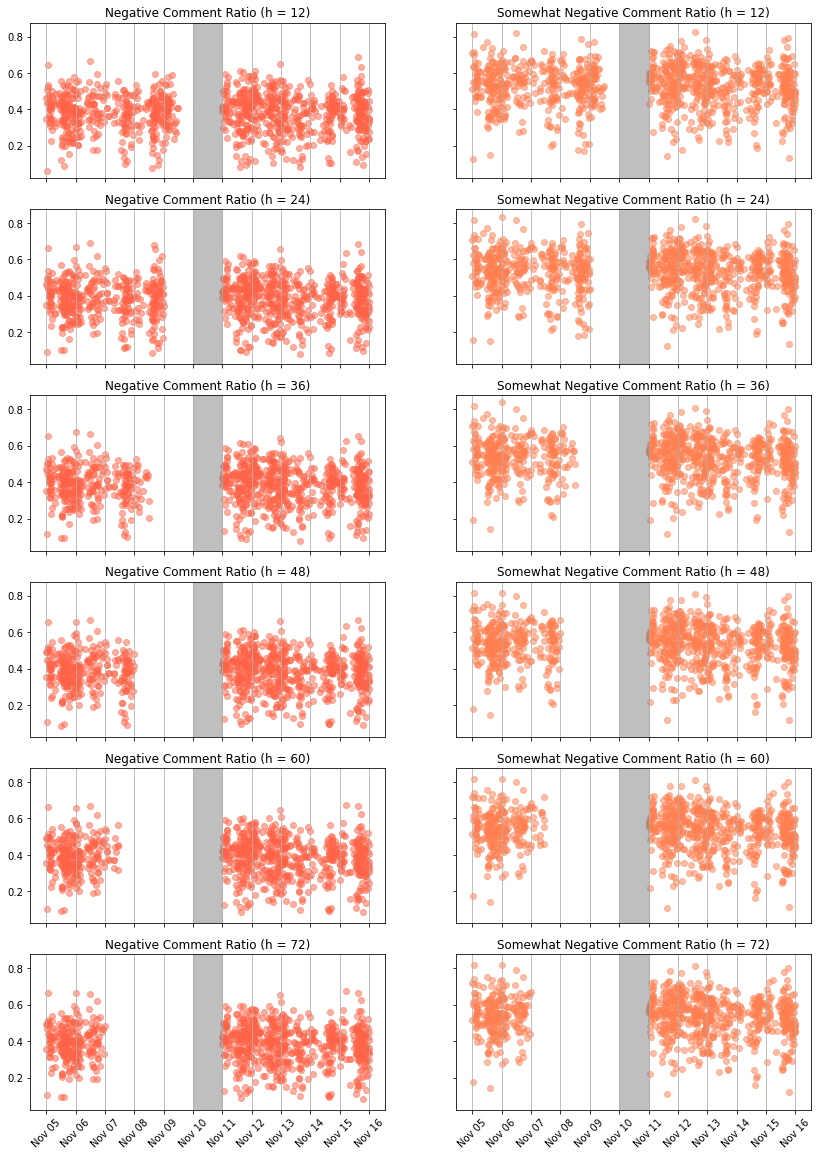

In [16]:
cols = [col for col in df.columns if 'ncr' in col]
fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True, sharey=True)
fig.set_figheight(20)
fig.set_figwidth(14)
for i in range(len(axs.flatten())):
    ax = axs.flatten()[i]
    # Time series
    m = df[sorted(windows * 2)[i].lower() + 'CommentsNum'] > 30
    x = df.loc[m, 'publishedAt']
    y = df.loc[m, cols[i]]
    color = 'tomato' if i % 2 == 0 else 'coral'
    ax.scatter(x, y, alpha=0.5, color=color)
    # Banned treatment region
    ax.axvspan(xmin=pd.Timestamp('2021-11-10'), xmax=pd.Timestamp('2021-11-11'),
               color='grey', alpha=0.5)
    # Ticks and labels
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_tick_params(rotation=45)
    # Aesthetics
    title = 'Negative Comment Ratio' if i % 2 == 0 else 'Somewhat Negative Comment Ratio'
    h = cols[i][-2:]
    ax.set_title(title + ' (h = ' + h + ')')
    ax.grid(which='major', axis='x')
plt.savefig('../../fig/fig_targets.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Regression Analysis

### 4.1. No running variable

In [17]:
# Add constant
df['const'] = 1

# List of independent variables
X = ['treat','const','logSeconds','titleSentiment','definition','biden','trump',
     'rittenhouse','climate','border','economy','covid','arbery','bannon']

# For each
for target in ['ncr1','ncr2']:
    for window in windows:
        # State case
        print(target + window)
        # First OLS model
        m0 = sm.OLS(endog=df[target + window], exog=df[X], missing='drop')
        m0_fit = m0.fit(cov_type='HC0')
        p = m0_fit.pvalues
        print(m0_fit.summary().tables[1])

        # Backwards stepwise selection
        while any(p > 0.1):
            p = m0_fit.pvalues.drop(['const','treat'])
            p = p[p > 0.1]
            if len(p) > 0:
                X.remove(p.idxmax())
                m0 = sm.OLS(endog=df[target + window], exog=df[X], missing='drop')
                m0_fit = m0.fit(cov_type='HC0')
                print('\nDropped ', p.idxmax())
                print(m0_fit.summary().tables[1])
        print('\n\n')

ncr1Post12
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
treat             -0.0142      0.008     -1.775      0.076      -0.030       0.001
const              0.1387      0.027      5.095      0.000       0.085       0.192
logSeconds         0.0219      0.003      6.413      0.000       0.015       0.029
titleSentiment    -0.0941      0.011     -8.559      0.000      -0.116      -0.073
definition         0.0768      0.020      3.824      0.000       0.037       0.116
biden              0.0164      0.010      1.565      0.118      -0.004       0.037
trump              0.0771      0.012      6.271      0.000       0.053       0.101
rittenhouse        0.1390      0.013     10.364      0.000       0.113       0.165
climate            0.0207      0.018      1.177      0.239      -0.014       0.055
border             0.0087      0.020      0.439      0.660      -0.030      

                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
treat             -0.0127      0.009     -1.448      0.148      -0.030       0.004
const              0.1923      0.030      6.472      0.000       0.134       0.251
logSeconds         0.0282      0.004      7.639      0.000       0.021       0.035
titleSentiment    -0.0823      0.012     -6.978      0.000      -0.105      -0.059
definition         0.1419      0.022      6.307      0.000       0.098       0.186
trump              0.0911      0.015      6.250      0.000       0.063       0.120
rittenhouse        0.1196      0.014      8.391      0.000       0.092       0.148
covid              0.0170      0.014      1.204      0.229      -0.011       0.045
arbery             0.0993      0.023      4.313      0.000       0.054       0.144
bannon             0.0352      0.021      1.643      0.100      -0.007       0.077

Dro

### 4.1. Linear f
$NCR_i = \beta_0 + \beta_1 T_i + \beta_2 R_i + \beta_3 T_i \times R_i + \beta_4 Sentiment_i + u_i$

In [18]:
X = ['treat','sut','treatSut','const','titleSentiment']
m = df['post12CommentsNum'] > 0
models = []
for target in ['ncr1','ncr2']:
    for window in windows:
        m0 = sm.OLS(endog=df.loc[m, target+window], exog=df.loc[m, X], missing='drop')
        m0 = m0.fit(cov_type='HC0')
        models.append(m0)
        print(target + window, round(m0.rsquared, 3))
        print(m0.summary().tables[1], '\n\n')

ncr1Post12 0.063
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
treat              0.0351      0.018      1.957      0.050   -5.67e-05       0.070
sut             6.441e-08   4.72e-08      1.365      0.172   -2.81e-08    1.57e-07
treatSut        2.516e-08   6.11e-08      0.412      0.680   -9.46e-08    1.45e-07
const              0.3264      0.013     24.806      0.000       0.301       0.352
titleSentiment    -0.1079      0.011    -10.021      0.000      -0.129      -0.087


ncr1Post24 0.066
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
treat              0.0393      0.021      1.870      0.061      -0.002       0.080
sut             6.888e-08   5.69e-08      1.211      0.226   -4.26e-08     1.8e-07
treatSut        2.035e-08   6.82e-08      0.299    

In [19]:
ncr1 = Stargazer(models[:6])
ncr1.dependent_variable_name('Dependent Variable: Negative Comment Ratio')
ncr1.custom_columns(['h = ' + str(i*12) for i in range(1,7)], [1]*6)
ncr1.covariate_order(['treat','treatSut','sut','titleSentiment','const'])
ncr1.show_degrees_of_freedom(False)
ncr1.add_custom_notes(['Robust standard errors (HC0)'])
ncr1

In [20]:
print(ncr1.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{6}{c}{\textit{Dependent Variable: Negative Comment Ratio}} \
\cr \cline{6-7}
\\[-1.8ex] & \multicolumn{1}{c}{h = 12} & \multicolumn{1}{c}{h = 24} & \multicolumn{1}{c}{h = 36} & \multicolumn{1}{c}{h = 48} & \multicolumn{1}{c}{h = 60} & \multicolumn{1}{c}{h = 72}  \\
\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) & (6) \\
\hline \\[-1.8ex]
 treat & 0.035$^{*}$ & 0.039$^{*}$ & 0.081$^{**}$ & 0.104$^{***}$ & 0.083$^{}$ & 0.105$^{}$ \\
  & (0.018) & (0.021) & (0.032) & (0.038) & (0.056) & (0.069) \\
 treatSut & 0.000$^{}$ & 0.000$^{}$ & -0.000$^{}$ & -0.000$^{}$ & -0.000$^{}$ & -0.000$^{}$ \\
  & (0.000) & (0.000) & (0.000) & (0.000) & (0.000) & (0.000) \\
 sut & 0.000$^{}$ & 0.000$^{}$ & 0.000$^{**}$ & 0.000$^{**}$ & 0.000$^{}$ & 0.000$^{}$ \\
  & (0.000) & (0.000) & (0.000) & (0.000) & (0.000) & (0.000) \\
 titleSentiment & -0.108$^{***}$ & -0.109$^{***}$ & -0.105$^{***

In [21]:
ncr2 = Stargazer(models[6:])
ncr2.dependent_variable_name('Dependent Variable: Somewhat Negative Comment Ratio')
ncr2.custom_columns(['h = ' + str(i*12) for i in range(1,7)], [1]*6)
ncr2.covariate_order(['treat','treatSut','sut','titleSentiment','const'])
ncr2.show_degrees_of_freedom(False)
ncr2.add_custom_notes(['Robust standard errors (HC0)'])
ncr2

In [22]:
print(ncr2.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{6}{c}{\textit{Dependent Variable: Somewhat Negative Comment Ratio}} \
\cr \cline{6-7}
\\[-1.8ex] & \multicolumn{1}{c}{h = 12} & \multicolumn{1}{c}{h = 24} & \multicolumn{1}{c}{h = 36} & \multicolumn{1}{c}{h = 48} & \multicolumn{1}{c}{h = 60} & \multicolumn{1}{c}{h = 72}  \\
\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) & (6) \\
\hline \\[-1.8ex]
 treat & 0.053$^{***}$ & 0.060$^{***}$ & 0.080$^{**}$ & 0.103$^{***}$ & 0.093$^{}$ & 0.073$^{}$ \\
  & (0.020) & (0.022) & (0.034) & (0.040) & (0.065) & (0.073) \\
 treatSut & -0.000$^{}$ & -0.000$^{}$ & -0.000$^{}$ & -0.000$^{}$ & -0.000$^{}$ & -0.000$^{}$ \\
  & (0.000) & (0.000) & (0.000) & (0.000) & (0.000) & (0.000) \\
 sut & 0.000$^{**}$ & 0.000$^{**}$ & 0.000$^{**}$ & 0.000$^{**}$ & 0.000$^{}$ & 0.000$^{}$ \\
  & (0.000) & (0.000) & (0.000) & (0.000) & (0.000) & (0.000) \\
 titleSentiment & -0.101$^{***}$ & -0.100$^{*

### 4.3 Linrear f(r) with backwards selection

In [23]:
# Covariates
X = ['treat','sut','treatSut','const',
      'definition','logSeconds','titleSentiment','biden','trump','rittenhouse',
      'climate','border', 'economy', 'covid', 'arbery', 'bannon', 'usa']

# Backwards Elim
m = df['post12CommentsNum'] > 0
for target in ['ncr1Post12','ncr2Post12']:
    print('\n'+target+'\n')
    # Fit model
    m0 = sm.OLS(endog=df.loc[m, target], exog=df.loc[m, X])
    m0_fit = m0.fit(cov_type='HC0')
    print('All covariates\n', m0_fit.summary().tables[1], sep='')
    # Get p-values
    p = m0_fit.pvalues.drop(['treat','sut','treatSut','const'])
    # Backwards iteration
    while any(p > 0.05):
        # Drop least significant control
        print('Dropped', p.idxmax())
        p = p.drop(p.idxmax())
        # Survivors
        X = ['treat','sut','treatSut','const'] + p.index.to_list()
        # Fit model
        m0 = sm.OLS(endog=df.loc[m, target], exog=df.loc[m, X])
        m0_fit = m0.fit(cov_type='HC0')
        print(m0_fit.summary().tables[1], '\n')
        # Get p-values
        p = m0_fit.pvalues.drop(['treat','sut','treatSut','const'])


ncr1Post12

All covariates
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
treat              0.0085      0.017      0.493      0.622      -0.025       0.042
sut             2.288e-08   4.54e-08      0.504      0.615   -6.62e-08    1.12e-07
treatSut         3.85e-08   5.87e-08      0.656      0.512   -7.65e-08    1.53e-07
const              0.1455      0.030      4.855      0.000       0.087       0.204
definition         0.0581      0.021      2.789      0.005       0.017       0.099
logSeconds         0.0226      0.003      6.709      0.000       0.016       0.029
titleSentiment    -0.0945      0.011     -8.632      0.000      -0.116      -0.073
biden              0.0155      0.011      1.469      0.142      -0.005       0.036
trump              0.0720      0.012      5.791      0.000       0.048       0.096
rittenhouse        0.1216      0.016      7.778      0.000 